# Simulations papier - données simulées


### 1. Génération


1.1. Génération des données

Variables du problème: On génère $n_{ech}$ séries temporelles par classe ($n_c$ classes et $n_b$ bandes).
On observe $T_i$ instants sur une grille fine de pas $1/\tau$ entre 0 et 1.

beta mesure la corrélation entre signaux:
$$
A_c = \begin{pmatrix}
      1 & \beta & \beta & \dots & \dots \\
      \beta & 1 & \beta & \dots & \dots \\
      \beta & \beta & 1 & \dots & \dots \\
      \vdots & \vdots & \vdots & \ddots & \dots \\
      \dots & \dots & \dots & \beta & 1
      \end{pmatrix}
$$
$A_c$ est carrée d'ordre $n_b$.

D'autre part $\lambda$ défini la variabilité des coefficients de projection de la moyennes. Ils sont générés selon la loi
$$
\boldsymbol{\alpha} \sim \mathcal{N}(\bar{\boldsymbol{\alpha}}, \lambda \mathbf{I})
$$
où $\bar{\boldsymbol{\alpha}} = 0$ ou $1$.

In [1]:
from simulations_papier import *


# Variables des données
n_ech = 200 # Nombre d'échantillons (par classe)

T_i_ = 10    # Longueur des séries temporelles
tau_ = 1000  # Taille de la grille d'échantillonage dans [0, 1]
beta_ = 0.5  # Dépendance spectrale (0 faible -> 1 forte)

n_c = 2      # Nombre de classes
n_b = 10     # Nombre de bandes

level_ = 1     # RBF level: variability -> (level_ * Sigma) \kron AA_T_ = Sigma \kron (level_ * AA_T_)
lambda_ = 0.02  # Variability of mean coefficients

# Set seed
seed_ = 1

In [2]:
# Train / Test split
ct = int(n_ech/2)

# extract functions
for c in range(n_c):
    # Seed for alpha
    np.random.seed(c*2)
    # Extract mean and covariances matrices
    A_c_, means_c, alpha_c = generate_mean(c = c, p = n_b, beta = beta_,
                                           lambda_ = lambda_, tau = tau_)
    # Set seed
    np.random.seed(seed_)

    # Generate random multivariate normal signals
    Gps_, complete_GPs_, Cs_ = generate_GPs(c = c, A_c = A_c_, means_c = means_c,
                                            n_times = T_i_, level = level_,
                                            n_sig = n_ech, tau = tau_)
    # Concatenate for each class
    if c == 0:
        # Train
        Gps_train, Cs_train = Gps_[:ct, ...], Cs_[:ct]
        complete_GPs_train = complete_GPs_[:ct, ...]
        # Test
        Gps_test, Cs_test = Gps_[ct:, ...], Cs_[ct:]
        complete_GPs_test = complete_GPs_[ct:, ...]
        
        # Correlation
        As_c = A_c_[np.newaxis, ...]
        alphas_c = alpha_c[np.newaxis, ...]
    else:
        # Train
        Gps_train = np.concatenate([Gps_train, Gps_[:ct, ...]], axis = 0)
        complete_GPs_train = np.concatenate([complete_GPs_train, complete_GPs_[:ct, ...]], axis = 0)
        Cs_train = np.concatenate([Cs_train, Cs_[:ct]], axis = 0)
        # Test
        Gps_test = np.concatenate([Gps_test, Gps_[ct:, ...]], axis = 0)
        complete_GPs_test = np.concatenate([complete_GPs_test, complete_GPs_[ct:, ...]], axis = 0)
        Cs_test = np.concatenate([Cs_test, Cs_[ct:]], axis = 0)
        
        # Correlation
        As_c = np.concatenate([As_c, A_c_[np.newaxis, ...]], axis = 0)
        alphas_c = np.concatenate([alphas_c, alpha_c[np.newaxis, ...]], axis = 0)
        
CLASSES = np.unique(Cs_train)

In [3]:
print(alphas_c[0])

[[ 0.03528105  0.00288087  0.02908547  0.01522075  0.0024335   0.00887726
   0.00667349  0.02988158 -0.00410317  0.00626135 -0.01708191]
 [ 0.00800314 -0.0510598   0.01307237  0.01728872 -0.0148433   0.04539509
  -0.02908731  0.00091517 -0.00374368  0.03065558  0.02938718]
 [ 0.01957476  0.00309895  0.00756325 -0.01775571 -0.03961593 -0.00695824
   0.00312698  0.02460581  0.0240476  -0.00774654 -0.00604606]
 [ 0.04481786 -0.02097106 -0.02840036 -0.0341254   0.03901551 -0.01019304
  -0.00876149 -0.02505591  0.01554981 -0.03227796 -0.00425481]
 [ 0.03735116 -0.01790933  0.00773805 -0.0102161  -0.02361264 -0.00056364
   0.00856664  0.00133034  0.00604944 -0.01268644 -0.00725482]
 [-0.01954556 -0.01344921 -0.00719106 -0.01626293 -0.03452565  0.00354852
  -0.00803562 -0.03260397  0.00925565 -0.01814597  0.00103891]
 [ 0.01900177  0.01458181  0.00257966  0.02278801 -0.02469652  0.00804683
  -0.0136962  -0.01741594 -0.01157699 -0.00623105  0.00112331]
 [-0.00302714 -0.023303    0.01801653  0.

1.2. Affichage

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

# Times
t_ = np.arange(0, tau_+1)
# Design matrix
J = alphas_c.shape[2]
Bt = np.empty((J, t_.size))
Js = np.linspace(0, J-1, J, dtype=int)
for l, t in enumerate(t_):
    Bt[:, l] = fourier_basis_functions(t, Js, tau_)

# Multiple bands
fig = plt.figure(figsize=(15,15))
bands = [0, 1, 9]
for bi in range(len(bands)):
    b = bands[bi]
    ax = fig.add_subplot(len(bands), 1, bi+1)
    
    ax.set_xlim((0, 1))
        
    # Class 0
    c = 0
    
    # Process mean
    ax.plot(t_/tau_, np.dot(alphas_c[c, b], Bt), 'r', label = "mean {}, band{}".format(c, b))
    # Print realizations
    for i in range(5):
        ax.plot(t_/tau_, complete_GPs_train[i, b + 1], 'r', alpha = 0.2)
        ax.plot(Gps_train[i, 0]/tau_, Gps_train[i, b + 1], 'r.', alpha = 0.8)
        
    # Class 1
    c = 1
    
    # Process mean
    ax.plot(t_/tau_, np.dot(alphas_c[c, b], Bt), 'b', label = "mean {}, band{}".format(c, b))
    # Print realizations
    for i in range(5):
        ax.plot(t_/tau_, complete_GPs_train[i + ct, b + 1], 'b', alpha = 0.2)
        ax.plot(Gps_train[i + ct, 0]/tau_, Gps_train[i + ct, b + 1], 'b.', alpha = 0.8)
        
    ax.set_xlabel("Time")
    ax.set_ylabel("R - Band {}".format(b))
    ax.legend()

fig.tight_layout()


Bad key savefig.frameon in file /scratch/aconstan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /scratch/aconstan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /scratch/aconstan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to g

### 2.Définition du modèle

Le modèle défini suit le même principe que les données simulées:

- La moyenne a une base de taille identique - Les fonctions de bases sont identiques.
- L'opérateur de covariance <ins>en temps</ins> est le même:
$$
\Sigma = RBF + W_n
$$

In [5]:
# Paramètres du modèle
K_dep = Ck(1, constant_value_bounds="fixed") * RBF(length_scale=200, length_scale_bounds=(1e-5, 1e5)) \
    + WhiteKernel(0.01, noise_level_bounds="fixed")
K_indep = Ck(10) * RBF(length_scale=300, length_scale_bounds=(1e-5, 1e5)) \
    + WhiteKernel(0.01)

basis_ = "fourier"
n_basis_ = int((J - 1)/2)

# Convergence
eps_ = 1e-12

Définition des modèles puis entraînement des paramètres

In [6]:
from mult_model_indep import M2GP as M2GP_indep

# Models
model = M2GP(kernel = K_dep, epsilon = eps_,
             base = basis_, n_basis = n_basis_,
             tau = tau_)

# model_indep = MIMGP(kernel = K_indep, epsilon = eps_,
#                     base = basis, n_basis_ = n_basis_,
#                     tau = tau_)

model_indep = M2GP_indep(kernel = K_indep, epsilon = eps_,
                         base = basis_, n_basis = n_basis_,
                         tau = tau_, n_restarts_optimizer=2)

In [7]:
# Fit (or load)
model.fit(Gps_train, Cs_train)
model_indep.fit(Gps_train, Cs_train)

# Predict
results = model.predict(Gps_test)
results_indep = model_indep.predict(Gps_test)

#### 2.1. Classification


##### Score M2GP

In [8]:
from sklearn.metrics import classification_report

# Scores
print(classification_report(Cs_test, results))

              precision    recall  f1-score   support

           0       0.73      0.92      0.81       100
           1       0.89      0.66      0.76       100

    accuracy                           0.79       200
   macro avg       0.81      0.79      0.79       200
weighted avg       0.81      0.79      0.79       200



##### Score MIMGP

In [9]:
# Scores
print(classification_report(Cs_test, results_indep))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       100
           1       0.84      0.87      0.85       100

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200



#### 2.2. Imputation

##### Reconstruction séries temporelles

On défini une grille dans [0, 1] de 100 points.
On reconstruit en ces 100 points la série temporelle.

In [10]:
from sklearn.metrics import mean_squared_error as MSE
# Time samples
t_input = np.arange(0, 1000, 10)
t_ = t_input.reshape(-1, 1)

# Imputation error, first dimension is for the model: 0-indep / 1-dep
err_tab = np.empty((2, Gps_test.shape[0], n_b, CLASSES.shape[0]))
for i in range(Gps_test.shape[0]):
    r_ = model.input_missing_values(Gps_test[i, :], t_, c = None)
    r_indep = model_indep.input_missing_values(Gps_test[i, :], t_, c = None)
    
    # Save error
    for b in range(n_b):
        err_tab[0, i, b, Cs_test[i]] = MSE(r_indep[b+1, :], complete_GPs_test[i, b+1, t_input])
        err_tab[1, i, b, Cs_test[i]] = MSE(r_[b+1, :], complete_GPs_test[i, b+1, t_input])

In [11]:
# Error for reconstruction: MIMGP then M2GP: 10 lines (10 bands) and 2 cols (2 classes)
print(np.mean(err_tab[0, :, :, :], axis = 0))
print(np.mean(err_tab[1, :, :, :], axis = 0))

[[ 4.20938723e-001  3.73300210e-001]
 [ 4.52131581e-001              nan]
 [ 4.30786289e-001 -7.20321661e+301]
 [ 4.40110067e-001  6.74111643e+261]
 [ 4.39973003e-001  3.67869026e-001]
 [ 4.44762149e-001  5.84742622e+010]
 [ 4.48449834e-001  2.65449325e+009]
 [ 4.34060729e-001 -9.81381256e+296]
 [ 4.46235461e-001 -5.14185809e+126]
 [ 4.41447929e-001  1.14107338e+191]]
[[0.79123179 0.40203948]
 [0.80967719 0.39981359]
 [0.78291602 0.36761891]
 [0.80972965 0.40443018]
 [0.80144451 0.38408238]
 [0.78063678 0.37609506]
 [0.84707635 0.40395375]
 [0.8054119  0.3874644 ]
 [0.8393575  0.389159  ]
 [0.83013979 0.40364487]]


### 3. Evaluation des paramètres du modèle

In [12]:
print("M2GP")
for c in CLASSES:
    print("Classe {}: {}".format(c, model.kernels["{}".format(c)]))
    print("Classe {}: {}".format(c, model_indep.kernels["{}".format(c)]))
print("\nMIMGP")
# for c in CLASSES:
#     for b in range(n_b):
#         if b == 0:
#             print("Classe {}, band {}: {}".format(c,b, model_indep.kernels["{}{}".format(c,b)]))
#         else:
#             print("          band {}: {}".format(b, model_indep.kernels["{}{}".format(c,b)]))

M2GP
Classe 0: 1**2 * RBF(length_scale=5e+03) + WhiteKernel(noise_level=0.01)
Classe 0: 0.993**2 * RBF(length_scale=116) + WhiteKernel(noise_level=0.505)
Classe 1: 1**2 * RBF(length_scale=1.17e+03) + WhiteKernel(noise_level=0.01)
Classe 1: 0.973**2 * RBF(length_scale=257) + WhiteKernel(noise_level=0.499)

MIMGP


In [13]:
for c in CLASSES:
    for b in range(n_b):
        print(c, b)
        print("MSE MIMGP: {}".format(MSE(model_indep.alpha_[c, b], alphas_c[c, b])))
        print("MSE M2GP:  {}".format(MSE(model.alpha_[c, b], alphas_c[c, b])))
    print()

0 0
MSE MIMGP: 0.0013881921982450997
MSE M2GP:  0.002515674647065992
0 1
MSE MIMGP: 0.0035853746072528753
MSE M2GP:  0.004035026726876256
0 2
MSE MIMGP: 0.0026755991134615187
MSE M2GP:  0.004625823814196498
0 3
MSE MIMGP: 0.003461911492121567
MSE M2GP:  0.005178485620227337
0 4
MSE MIMGP: 0.005365942879337418
MSE M2GP:  0.0063620820880954275
0 5
MSE MIMGP: 0.0028089051992472233
MSE M2GP:  0.003625280765297201
0 6
MSE MIMGP: 0.0036263984109851087
MSE M2GP:  0.004646079906902301
0 7
MSE MIMGP: 0.004003717779556191
MSE M2GP:  0.00436302876880516
0 8
MSE MIMGP: 0.0054779112316456526
MSE M2GP:  0.007562747472607805
0 9
MSE MIMGP: 0.0023662762210366773
MSE M2GP:  0.0034420346692576073

1 0
MSE MIMGP: 0.0022871143290774686
MSE M2GP:  0.0024184935987189558
1 1
MSE MIMGP: 0.003956919190062375
MSE M2GP:  0.0024062316023299147
1 2
MSE MIMGP: 0.002005230443281846
MSE M2GP:  0.0014972328677569221
1 3
MSE MIMGP: 0.0032124290887838272
MSE M2GP:  0.002224164632322315
1 4
MSE MIMGP: 0.00517156957319538

In [14]:
from sklearn.metrics.pairwise import pairwise_distances

for c in CLASSES:
    print(c)
    print(np.mean(pairwise_distances(model.AA_T_[c], As_c[c])))
    print()

0
158.19955422328005

1
83.9067733275221



In [15]:
print("True matrix")
print(np.dot(As_c[0], As_c[0].T))

print("\nPredicted matrix")
for c in CLASSES:
    print("\nClasse {}: rapport entre valeur (0, 1) et diagonale (0, 0) = {}".format(c, model.AA_T_[c][0, 1] / model.AA_T_[c][0, 0]))
    print(model.AA_T_[c])

True matrix
[[1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 1.  0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 1.  0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 1.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 1.  0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 1.  0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 1.  0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 1. ]]

Predicted matrix

Classe 0: rapport entre valeur (0, 1) et diagonale (0, 0) = 0.517569477189009
[[88.82791607 45.97461808 48.16868363 45.31409272 42.96231398 46.64162454
  47.32841061 44.58472986 42.62553241 44.49214845]
 [45.97461808 83.46985968 43.72072611 48.88740916 43.33974482 44.94460923
  44.17589691 40.64844752 40.22152923 42.33734099]
 [48.16868363 43.72072611 92.86901056 45.96820909 43.6319189  45.13530371
  43.65810869 45.04061023 42.94322019 44.81198744]
 [45.31409272 48.88740916 45.96820909 88.37640352 42.47849683 43.99870811
  46.944875

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
# Print Ac t(Ac)
fig = plt.figure(figsize=(15,15))

for c in range(CLASSES.shape[0]):
    ax = fig.add_subplot(CLASSES.shape[0], 2, c*2+1)
    # Plot matrix for A
    ax.matshow(np.dot(As_c[c], As_c[c].T))
    ax.set_xlabel("True")
    ax.set_ylabel("Class {}".format(CLASSES[c]))
        
    ax = fig.add_subplot(CLASSES.shape[0], 2, c*2+2)
    # Plot matrix for A
    ax.matshow(model.AA_T_[c])
    ax.set_xlabel("Predicted")
    
fig.suptitle("Wavelengths dependency - Comparison", y=0.99)
fig.tight_layout()

In [17]:
# Compute empirical mean

values, cnt = np.zeros((n_b, tau_)), np.zeros((tau_))
for i in range(Gps_train.shape[0]):
    for it in range(len(Gps_train[i, 0])):
        t_it = int(Gps_train[i, 0][it]) - 1
        cnt[t_it] += 1
        for b in range(n_b):
            values[b, t_it] += Gps_train[i, b+1][it]
            
for b in range(n_b):
    values[b, :] = np.divide(values[b, :], cnt)

/scratch/aconstan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


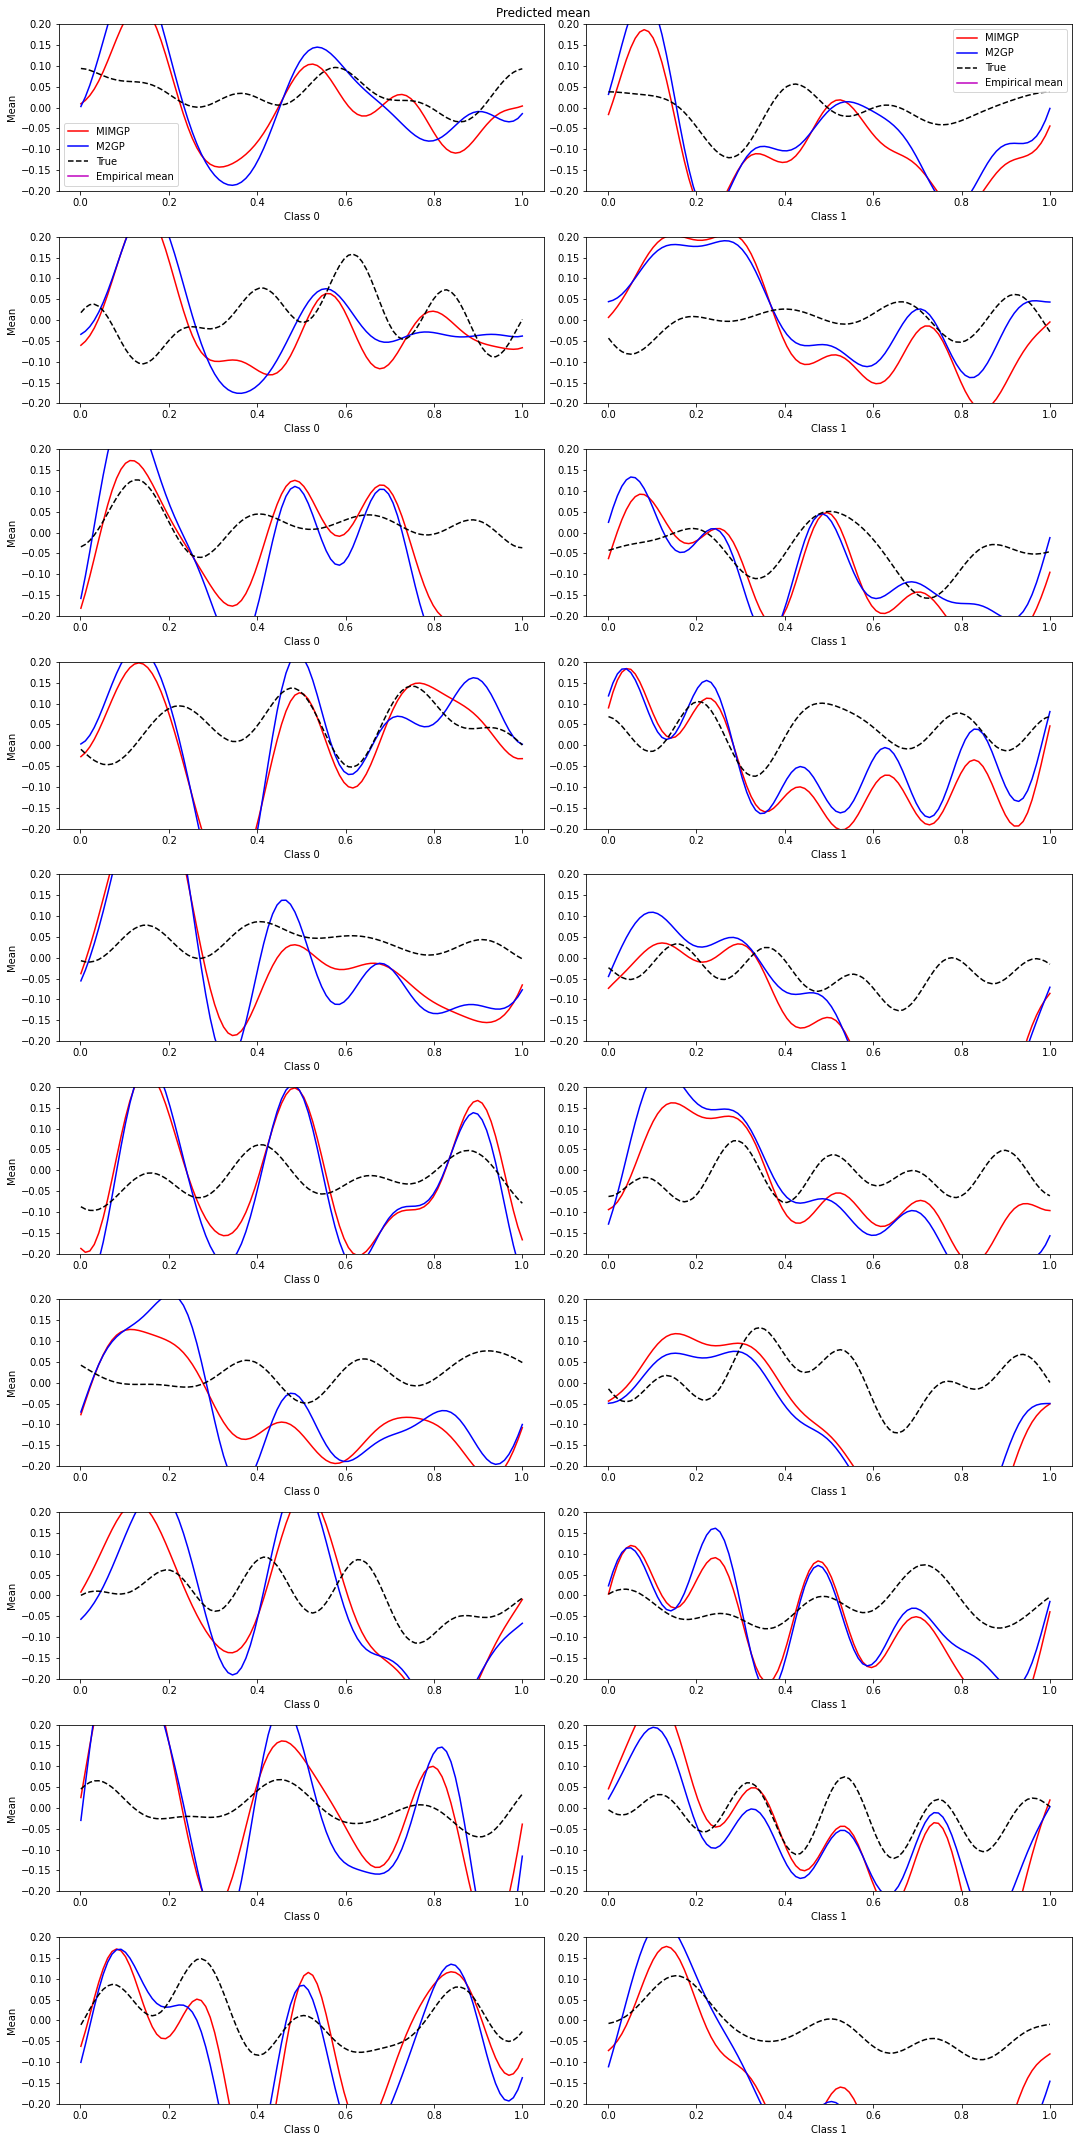

In [18]:
# Print means

# Smooth values
l_mask = 20
mask = np.ones(l_mask) / l_mask
values_smoothed = np.empty_like(values)
for b in range(n_b):
    values_smoothed[b, :] = np.convolve(values[b, :], mask, mode = "same")

# Plots
%matplotlib inline

t = np.linspace(1, tau_, 100)
B = model.design_matrix(t_)

fig = plt.figure(figsize=(15, 30))

for c in range(CLASSES.shape[0]):
    mean = np.dot(model.alpha_[c, :], B)
    mean_indep = np.dot(model_indep.alpha_[c, :], B)
    true_mean = np.dot(alphas_c[c, :], B)
    
    for b in range(n_b):
        ax = fig.add_subplot(n_b, CLASSES.shape[0], b*2+(c+1))
        ax.plot(t/1000, mean_indep[b], 'r', label = "MIMGP")
        ax.plot(t/1000, mean[b], 'b', label = "M2GP")
        ax.plot(t/1000, true_mean[b], 'k--', label = "True")
        ax.plot(np.linspace(1, tau_, 1000)/1000, values_smoothed[b, :], 'm', label = "Empirical mean")
        ax.set_ylim(-0.2, 0.2)
        ax.set_xlabel("Class {}".format(CLASSES[c]))
        if c == 0:
            ax.set_ylabel("Mean")
        if b == 0:
            ax.legend()
        
#         ax = fig.add_subplot(n_b, CLASSES.shape[0], b*2+(c+1))
#         ax.plot(t/100, mean[b])
#         ax.set_ylim(-0.5, 0.3)
#         ax.set_xlabel("Mean M2GP")
    
fig.suptitle("Predicted mean", y=0.99)
fig.tight_layout()